# Noah Miller GitHub Python Project 3: Recommender System using Amazon Beauty Products

The purpose of this notebook is for me to gain more understanding with recommender systems. Intuitively, this makes sense to me based on my experienced with Amazon and Netflix in particular. Their recommender systems, whether for shopping or watching content, are both great in either making me feel like I should buy a particular product or start watching a new show. Therefore, for this project, I will try to recreate a recommender system in Python using the dataset of Amazon beauty products from https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings.


## Step 1: Importing Data and some Necessary Libraries

First I'm going to import the libraries I will be using.

In [1]:
import pandas as pd  # Just really good for reading in data in a tabular format
import numpy as np  # You never know when you'll need to do some numerical manipulations
import matplotlib.pyplot as plt  # Good for some visual EDA
import warnings  # Used to filter out warnings
warnings.filterwarnings('ignore')  # Tells Python to ignore warnings
import multiprocess as mp  # Useful for some parallel computing if we need it
from datetime import datetime  # For converting seconds to a date

With these libraries loaded, now I will import my data and look at some statistics about it both in terms of the data itself as well as its size; I believe being able to manage your data from statistical and algorithmic perspectives alike are necessary for efficient data science.

In [2]:
transactions = pd.read_csv('/Users/noahmiller/Downloads/ratings_Beauty.csv')  # Importing our data
transactions.head()  # Taking a look at the first few lines of our data

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


Here we appear to have a data from consisting of four columns. We have a UserId column, representing a unique string identifying the purchaser of the product. The ProductId column represents the unique identifyer for the product that was purchased. Rating refers to the number of stars, from 1 to 5, the purchaser assigned to the product. Ratings with 1 star are very bad while ratings of 5 are very good. Interestingly, it looks like the rating column only consists of whole numbers despite being represented as a float. Finally, we have a timestamp column representing seconds since January 1st, 1970. I am going to use this in some way, though.

Let's look at some info concerning the memory of the data.

In [3]:
transactions.info()  # Returns information about dataframe and memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


Here we can see our dataset consists of 2,023,070 entries and the data frame consists of roughly 62 megabytes of memory usage. This seems quite managable; for other projects, I've had to sample data instead because I cannot fit all of it into Python at once since it was so big. In this case, this is much more reasonable.

Next I would like to look at some visual statistics of this data set. I think UserId and ProductId are too unique right now to have any meaningful statistics performed on them, so let's instead focus on rating and timestamp. This allows us to see the distribution of both columns.

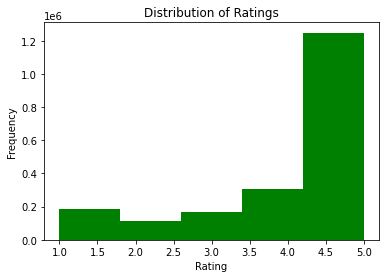

In [4]:
plt.hist(transactions['Rating'], bins=5, color="green")  # Creating a histogram for ratings
plt.xlabel('Rating')  # Label for x-axis
plt.ylabel('Frequency')  # Label for y-axis
plt.title('Distribution of Ratings')  # Title
plt.show()

We can see that five-star ratings are VERY frequent with roughly 1.2 million of these reviews consisting of five-star ratings. To be honest, this does surprise me since I would think, at first, that negative reviews are much more likely. I would imagine displeased customers would want to share their frustrations, while satisfied customers may not have that urgency.

Next let's view the timestamp histogram. I'll convert this into a nicer date format instead of just seconds. Since we have to do this across roughly 2 million records, this is a good excuse to show how preprocessing like this can easily be accomplished with parallel processing.

In [5]:
def seconds_to_date(tStamp):
    # tStamp refers to a Unix timestamp
    return int(datetime.fromtimestamp(tStamp).strftime("%Y"))  # Returning year as an integer

with mp.Pool(mp.cpu_count()) as pool:  # Processing in parallel
    # This format works super well for preparing data in a parallel fashion
    transactions['Year'] = pool.map(seconds_to_date, transactions['Timestamp'])  # Mapping function to multiple cores
    pool.close()  # This line and line below ensure core cluster closes safely
    pool.join()
    
transactions.head()  # Ensuring this returns the date in the proper format

,UserId,ProductId,Rating,Timestamp,Year
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200,2013
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200,2012
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200,2014
3,A1WMRR494NWEWV,0733001998,4.0,1382572800,2013
4,A3IAAVS479H7M7,0737104473,1.0,1274227200,2010


Let's take a look at the distribution of ratings through the years.

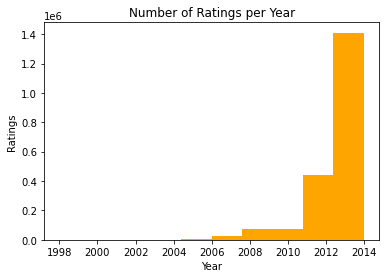

In [6]:
plt.hist(transactions['Year'], bins=10, color="orange")
plt.xlabel('Year')
plt.ylabel('Ratings')
plt.title('Number of Ratings per Year')
plt.show()

It looks like the maximum year here is 2014. This shows me that this data is quite old in comparison to today. We can still use this for the sake of exercise, however. Likewise, this shows me the exponential rate at which Amazon is recieving customers as well as reviews. This could very easily become a big data problem if trends continue at this rate. 

Also if this number of ratings seems small, recall that this is focused on beauty products instead of ALL of Amazon's sales.

## Step 2: Recommendation System using Collaborative Filtering

Here, I will be using the scikit-surprise library, which is a library for implementing recommendation systems via collaborative filtering. I borrowed from the documentation found here: https://surprise.readthedocs.io/en/stable/getting_started.html

In [7]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection.validation import cross_validate  # To ensure our data is usable through cross-validation
reader = Reader(rating_scale=(1,5))  # Telling the reader function the rating scale; this should be specified for ratings systems that do not go from 1 to 5.
data = Dataset.load_from_df(transactions[['UserId', 'ProductId', 'Rating']], reader)  # Creating format to be accepted by the algorithm below
algo = SVD(random_state=123)  # SVD is useful for recommender systems; setting to 123 for consistent results

The reader and dataset tools are used to transform our original data into something more understandable by the underlying algorithm. SVD stands for 'singular value decomposition' and is a matrix factorization function, which essentially means it is able to return the more useful parts of a matrix. It can be used for dimensionality reduction as well. It is very popular for recommender systems. For more information, visit https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/.

In [8]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True, n_jobs=-1)
# Here we're cross-validating our data. I am using n_jobs = -1 to use all the processors I can 

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2469  1.2482  1.2516  1.2492  1.2504  1.2493  0.0017  
MAE (testset)     0.9760  0.9765  0.9785  0.9770  0.9770  0.9770  0.0008  
Fit time          154.89  159.62  158.20  155.76  157.01  157.10  1.69    
Test time         6.82    6.10    7.20    6.46    3.18    5.95    1.43    


{'test_rmse': array([1.24685913, 1.24817448, 1.25159463, 1.24921896, 1.25043357]),
 'test_mae': array([0.97601783, 0.97649845, 0.97847261, 0.97701516, 0.97699264]),
 'fit_time': (154.88916301727295,
  159.61985683441162,
  158.19871497154236,
  155.7611210346222,
  157.01192593574524),
 'test_time': (6.815099716186523,
  6.104542970657349,
  7.1976470947265625,
  6.45526385307312,
  3.17940092086792)}

It looks like our tests were very consistent here. The RMSE and MAE results in each fold have very small standard deviations, which is a very good sign.

Now I am going to create training and testing data sets to train a model and then determine its accuracy. I will be training on 80 percent of the data and then testing on the remaining 20 percent. We will be comparing against existing user ratings. In the real world, we would only be returned with scores of a projected rating for a product; products with high scores might be presented to end users as potential products to purchase, for example.

In [9]:
from surprise.model_selection import train_test_split  # Useful for splitting data into training and testing sets
train, test = train_test_split(data, test_size=.20)  # 20 percent of the data will be used for testing
algo.fit(train)  # Training model on the training data set
review_predictions = algo.test(test)  # Testing on our est dataset

We've now trained the model on our training data, but how accurate are we? I'll use some functions from surprise's accuracy tool to look at some statistics concerning how well we did.

In [10]:
from surprise import accuracy  # Contains functions to determine how well the model performed
accuracy.rmse(review_predictions)  # Returns root mean square error
accuracy.mse(review_predictions)  # Returns mean square error
accuracy.mae(review_predictions)  # Returns mean actual error
accuracy.fcp(review_predictions)  # Returns fraction of concordant pairs 
print("")  # For some reason MAE gets printed twice, so this is like a buffer for that

RMSE: 1.2486
MSE: 1.5591
MAE:  0.9765
FCP:  0.5154



These results are quite similar to the results of our cross-validation. On average, it seems like our recommendations are off by less than 1 star; the significance of this is arguable, but for a first pass it could be acceptable. I'd like to try running this again with more data to see if we can converge towards a lower value.

Overall, I am surprised how quickly and easily this kind of recommender system could be created, especially for data with over 2 million records. I can imagine the implementation and scaling of this algorithm is more difficult, but this is a good start. Likewise, this was new for me as far as data science is concerned. I can see how a model like this could be used to determine which products should be recommended on a user's shopping page on a website like Amazon or eBay or watch page, in the case of services like Netflix or Hulu. 

# Project Information

Source for Data:
https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings

System Information:
2020 M1 MacBook Pro, 16 GB Unified Memory